# Assignment 7: Segmenting behavioral videos with autoregressive HMMs

**STATS305C: Applied Statistics III**

_Stanford University. Spring, 2022._

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slinderman/stats305c/blob/master/assignments/hw7/hw7.ipynb)


---

**Name:**
Isaac

**Names of any collaborators:**
Saskia C., Sunny S.

---


![](https://ars.els-cdn.com/content/image/1-s2.0-S0896627315010375-gr1.jpg)

In this lab we'll develop hidden Markov models, specifically Gaussian and autoregressive hidden Markov models, to analyze depth videos of freely behaving mice. We'll implement the model developed by Wiltschko et al (2015) and extended in Markowitz et al (2018). Figure 1 of Wiltschko et al is reproduced above. 

**References**

Markowitz, J. E., Gillis, W. F., Beron, C. C., Neufeld, S. Q., Robertson, K., Bhagat, N. D., ... & Sabatini, B. L. (2018). The striatum organizes 3D behavior via moment-to-moment action selection. Cell, 174(1), 44-58.

Wiltschko, A. B., Johnson, M. J., Iurilli, G., Peterson, R. E., Katon, J. M., Pashkovski, S. L., ... & Datta, S. R. (2015). Mapping sub-second structure in mouse behavior. Neuron, 88(6), 1121-1135.


# Environment Setup

In [1]:
%%capture
!pip install pynwb
!wget -nc https://raw.githubusercontent.com/slinderman/stats305c/main/assignments/hw7/helpers.py
!wget -nc https://www.dropbox.com/s/564wzasu1w7iogh/moseq_data.zip
!unzip -n moseq_data.zip

In [2]:
# First, import necessary libraries.
import torch
from torch.distributions import MultivariateNormal, Categorical
import torch.nn.functional as F

from dataclasses import dataclass
from tqdm.auto import trange
from google.colab import files

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
sns.set_context("notebook")

# We've written a few helpers for plotting, etc.
import helpers

# Part 1: Implement the forward-backward algorithm

First, implement the forward-backward algorithm for computing the posterior distribution on latent states of a hidden Markov model, $q(z) = p(z \mid x, \Theta)$. Specifically, this algorithm will return a $T \times K$ matrix where each entry represents the posterior probability that $q(z_t = k)$.

## Problem 1a [Code]: Implement the forward pass

As we derived in class, the forward pass recursively computes the _normalized_ forward messages $\tilde{\alpha}_t$ and the marginal log likelihood $\log p(x \mid \Theta) = \sum_{t} \log A_t$.

**Notes**:
- This function takes in the _log_ likelihoods, $\log \ell_{tk}$, so you'll have to exponentiate in the forward pass
- You need to be careful exponentiating though. If the log likelihoods are very negative, they'll all be essentially zero when exponentiated and you'll run into a divide-by-zero error when you compute the normalized forward message. Alternatively, if they're large positive numbers, your exponent will blow up and you'll get nan's in your calculations. 
- To avoid numerical issues, subtract $\max_k (\log \ell_{tk})$ prior to exponentiating. It won't affect the normalized messages, but you will have to account for it in your computation of the marginal likelihood.


In [8]:
def forward_pass(initial_probs, transition_matrix, log_likes):
    """
    Perform the (normalized) forward pass of the HMM.

    Parameters
    ----------
    initial_probs: $\pi$, the initial state probabilities. Length K, sums to 1.
    transition_matrix: $P$, a KxK transition matrix. Rows sum to 1.
    log_likes: $\log \ell_{t,k}$, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    alphas: TxK matrix with _normalized_ forward messages $\tilde{\alpha}_{t,k}$
    marginal_ll: Scalar marginal log likelihood $\log p(x | \Theta)$
    """
    T, K = log_likes.shape
    # instantiate alphas and marginal ll // address t=0 base case
    alphas = [None for _ in range(T)]# torch.zeros_like(log_likes)
    alphas[0] = initial_probs # t=0

    # instantiate marginal log likelihood
    marginal_ll = torch.logsumexp(torch.log(alphas[0]) + log_likes[0], dim=0) # t=0 case

    for t in range(1, T):
        #### compute unnormalized alpha t+1 #####
        # compute log product
        log_alpha_unnorm = (
            torch.log(transition_matrix.T) # (K, K); row from, column to
            + torch.log(alphas[t-1]).reshape(-1, 1) # (K, 1)
            + log_likes[t-1].reshape(-1, 1) # (K, 1)
            # by transposing, we're collapsing over z_{t+1}, the thing to sum over
        ) # (K, K)
        log_alpha_norm = torch.logsumexp(log_alpha_unnorm, axis=0) # (K, 1)
        ### Normalize softmax ###
        offset = torch.max(log_alpha_norm)
        log_alpha_norm -= offset
        # compute new forward pass value
        alphas[t] = F.softmax(log_alpha_norm, dim=0)
        # update marginal LL: normalized_a_t * p(x_t | z_t)
        marginal_ll += (torch.logsumexp(torch.log(alphas[t]) + log_likes[t], dim=0))
    alphas = torch.torch.stack(alphas)
    return alphas, marginal_ll

## Problem 1b [Code]: Implement the backward pass

Recursively compute the backward messages $\beta_t$. Again, normalize to avoid underflow, and be careful when you exponentiate the log likelihoods. The same trick of subtracting the max before exponentiating will work here too.

In [9]:
def backward_pass(transition_matrix, log_likes):
    """
    Perform the (normalized) backward pass of the HMM.

    Parameters
    ----------
    transition_matrix: $P$, a KxK transition matrix. Rows sum to 1.
    log_likes: $\log \ell_{t,k}$, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    betas: TxK matrix with _normalized_ backward messages $\tilde{\beta}_{t,k}$
    """
    ##
    T, K = log_likes.shape
    # betas
    betas =  [None for _ in range(T)] # torch.zeros_like(log_likes)
    betas[-1] = torch.ones(K) / K # t=T
    for t in range(T-2, -1, -1):
        #### compute unnormalized alpha t+1 #####
        # compute log product
        log_product = (
            torch.log(betas[t+1]).reshape(-1, 1) # (K, 1)
            + log_likes[t+1].reshape(-1, 1) # (K, 1)
            + torch.log(transition_matrix) # (K, K); 
        )
        log_b_t = torch.logsumexp(log_product, axis=0)
        
        #### Normalize #####
        # numerics
        log_b_t -= torch.max(log_b_t)
        # update
        betas[t] = F.softmax(log_b_t, dim=0)
    betas = torch.stack(betas)
    ##
    return betas


## Problem 1c [Code]: Combine the forward and backward passes

Compute the posterior marginal probabilities. We call these the `expected_states` because $q(z_t = k) = \mathbb{E}_{q(z)}[\mathbb{I}[z_t = k]]$. To compute them, combine the forward messages, backward messages, and the likelihoods, then normalize. Again, be careful when exponentiating the likelihoods.

In [10]:
@dataclass
class HMMPosterior:
    expected_states: torch.Tensor
    marginal_ll: float
    

def forward_backward(initial_probs, transition_matrix, log_likes):
    """
    Fun the forward and backward passes and then combine to compute the 
    posterior probabilities q(z_t=k).

    Parameters
    ----------
    initial_probs: $\pi$, the initial state probabilities. Length K, sums to 1.
    transition_matrix: $P$, a KxK transition matrix. Rows sum to 1.
    log_likes: $\log \ell_{t,k}$, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    posterior: an HMMPosterior object
    """
    ##

    alphas, marginal_ll = forward_pass(initial_probs, transition_matrix, log_likes)
    betas = backward_pass(transition_matrix, log_likes)
    # dim check 
    assert alphas.shape == betas.shape
    assert alphas.shape == log_likes.shape
    # logits for k
    log_alpha_l_beta = torch.log(alphas) + log_likes + torch.log(betas)

    # numerics
    log_alpha_l_beta -= log_alpha_l_beta.max(dim=1, keepdims=True).values
    # --> probs
    expected_states = F.softmax(log_alpha_l_beta, dim=1)
    #
    # Package the results into a HMMPosterior
    return HMMPosterior(
        expected_states=expected_states,
        marginal_ll=marginal_ll
    )

## Time it on some more realistic sizes

It should take about 3 seconds for a $T=36000$ time series with $K=50$ states. 

In [6]:
%timeit forward_backward(*helpers.random_args(36000, 50))

1 loop, best of 5: 6.01 s per loop


# Part 2: Gaussian HMM

First we'll implement a hidden Markov model (HMM) with Gaussian observations. This is the same model we studied in class,
\begin{align}
p(x, z; \Theta) &= \mathrm{Cat}(z_1; \pi) \prod_{t=2}^{T} \mathrm{Cat}(z_t; P_{z_{t-1}}) \prod_{t=1}^T \mathcal{N}(x_t; \mu_{z_t}, \Sigma_{z_t})
\end{align}
with parameters $\Theta = \pi, P, \{\mu_k, \Sigma_k\}_{k=1}^K$. The observed datapoints are $x_t \in \mathbb{R}^{D}$ and the latent states are $z_t \in \{1,\ldots, K\}$.

## Problem 2a [Code]: Complete the following GaussianHMM class

Finish the code below to implement a `GaussianHMM` object. Specifically, complete the following functions:
- `sample`: to simulate from the joint distribution $p(z_{1:T}, x_{1:T})$.
- `e_step`: to compute the posterior expectations and marginal likelihood using the `forward_backward` function you wrote in Part 1.
- `m_step`: to update the parameters by maximizing the expected log joint probability under the posterior from `e_step`.
- `fit`: to run the EM algorithm.

Notes:
- Recall that in Homework 4 you derived the M-step for a Gaussian mixture model with a normal-inverse Wishart prior distribution. You can reuse the same calculations for the M-step of the Gaussian HMM. Here, we are assuming an improper uniform prior on the parameters $(\mu_k, \Sigma_k)$, but you can think of that as a normal-inverse-Wishart prior with parameters $\mu_0=0$, $\kappa_0=0$, $\Sigma_0=0$, and $\nu_0=-(D+2)$. 
- For numerical stability, in the M-step you may need to add a small amount to the diagonal of $\Sigma_k$ and explicitly make it symmetric; e.g. after solving for the optimal covariance do,
```
Sigma = 0.5 * (Sigma + Sigma.T) + 1e-4 * torch.eye(self.data_dim)
```
You can think of this as a very weak NIW prior.
- We will **keep the initial distribution and transition matrix fixed** in this code!


In [11]:
class GaussianHMM:
    """Simple implementation of a Gaussian HMM.
    """
    def __init__(self, num_states, data_dim):
        self.num_states = num_states
        self.data_dim = data_dim

        # Initialize the HMM parameters
        self.initial_probs = torch.ones(num_states) / num_states
        self.transition_matrix = \
            0.9 * torch.eye(num_states) + \
            0.1 * torch.ones((num_states, num_states)) / num_states
        self.emission_means = torch.randn(num_states, data_dim)
        self.emission_covs = torch.eye(data_dim).repeat(num_states, 1, 1)

    def sample(self, num_timesteps, seed=0):
        """Sample the HMM
        """
        # Set random seed
        torch.manual_seed(seed)

        # Initialize outputs
        states = torch.full((num_timesteps,), -1, dtype=int)
        data = torch.zeros((num_timesteps, self.data_dim))

        ## 
        states[0] = torch.distributions.Categorical(probs=self.initial_probs).sample()
        for t in range(num_timesteps):
            # extract state
            state = states[t]
            # slice down 0 axis (K)
            mu_t = self.emission_means[state]
            cov_t = self.emission_covs[state]
            # sample emission
            emission = torch.distributions.MultivariateNormal(
                loc=mu_t, 
                covariance_matrix=cov_t
            ).sample()
            assert emission.shape == data[0].shape
            # dim check
            data[t] =  emission
            # get next state from FIXED transition prob
            if t < num_timesteps - 1:
                trans_probs = self.transition_matrix[state]
                states[t+1] = torch.distributions.Categorical(probs=trans_probs).sample()
        ##

        return states, data

    def compute_ll(self, data):
        """
        Computes log-likelihood on some data
        """
        return torch.distributions.MultivariateNormal(
            self.emission_means,  # (K, D)
            self.emission_covs # (K, D, D)
        ).log_prob(
            data.unsqueeze(1) # (N, D) --> (N, 1, D)
        )

    def compute_marginal_ll(self, data):
        """
        """
        _, marginal_ll = forward_pass(
            self.initial_probs, 
            self.transition_matrix,
            self.compute_ll(data)
        )
        return marginal_ll

    def e_step(self, data):
        """Run the forward-backward algorithm and return the posterior distribution
        over latent states given the data and the current model parameters.
        """
        ##
        # YOUR CODE HERE
        # ll = torch.distributions.MultivariateNormal(
        #     self.emission_means,  # (K, D)
        #     self.emission_covs # (K, D, D)
        # ).log_prob(
        #     data.unsqueeze(1) # (N, D) --> (N, 1, D)
        # )
        ll = self.compute_ll(data)

        posterior = forward_backward(
            self.initial_probs,
            self.transition_matrix,
            ll
        )
        return posterior

    def m_step(self, data, posterior):
        """Perform one m-step to update the emission means and covariance given the
        data and the posteriors output by the forward-backward algorithm.
        
        NOTE: We will keep the initial distribution and transition matrix fixed!
        """
        ##
        ### code retrieved from HW4 GMM M-Step ###

        ####################################################
        ### Setup like HW4 ###
        X = data
        D, K = self.data_dim, self.num_states # data.shape[0]
        q = posterior.expected_states # posterior probabilities

        ####################################################
        # hyper parameters, specified by probelm 
        mu0 = torch.zeros(D) 
        kappa0 = 0
        Sigma0 = torch.eye(D)
        nu0 = -(D + 2)

        ### parameterize the NIW ###

        ### X.T @ W @ X, but W is a K-dim diagonal
        WX = torch.mul(
            X.unsqueeze(2), # (N, D, 1)
            q.unsqueeze(1)  # (N, 1, K)
        ) # --> (N, D, K); listcomp over K

        XTWX = torch.stack([X.T @ WX[:, :, k] for k in range(K)])

        ### K is the first dimension everywhere

        ### v': v0 + \sum_{n} w_{n, k}
        nu_post = nu0 + q.sum(axis=0) # (K, ) #  + D + 2
        assert nu_post.shape == torch.Size([K])

        ### k': k0 + \sum_{n} w_{n, k}
        kappa_post = kappa0 + q.sum(axis=0) # (K, )
        assert kappa_post.shape == torch.Size([K])

        ### u': (1 / k') * (k0u0 + \sum_{n}w_{n, k} x_n)
        mu_post = kappa0 * mu0 + torch.mul(
            q.T.unsqueeze(2), # (K, N, 1)
            X.unsqueeze(0) # (1, N, D)
        ).sum(axis=1) # --> (K, D)
        mu_post = torch.divide(mu_post, kappa_post.unsqueeze(1)) # (K, D) / (K, 1) --> (K, D)
        assert mu_post.shape == torch.Size([K, D])


        ### Sigma': Sigma0 + k0u0u0^T + \sum_{n}w{n, k}x_nx_n^T - k'uu'
        Sigma_post = torch.add(
            # (D, D) -> (1, D, D)
            torch.add(Sigma0, kappa0 * torch.outer(mu0, mu0)).unsqueeze(0),
            # (K, D, D)
            # torch.stack([X.T @ torch.diag(qk) @ X for qk in q.T])
            XTWX 
        ) # -> (K, D, D)
        assert Sigma_post.shape == torch.Size([K, D, D])
        kuuT= torch.stack(
            [ # my nonclever attempt after failing at broadcasting
                kappa_post[k] * torch.outer(mu_post[k], mu_post[k]) 
                for k in range(K)
            ]
        ) # (K, D, D)
        assert kuuT.shape == torch.Size([K, D, D])
        Sigma_post = torch.add(Sigma_post, -kuuT) # (K, D, D)


        mus_map = mu_post
        Sigmas_map = torch.mul(
            # + 2 for MAP
            (1. / (nu_post + D + torch.tensor(2.))).unsqueeze(1).unsqueeze(2), # (K, 1, 1)
            Sigma_post # (K, D, D)
        ) # --> (K, D, D)

        ### Numeric adjustment ###
        Sigmas_map = torch.stack([
            0.5 * (item + item.T) + 1e-4 * torch.eye(D)
            for item in Sigmas_map
        ])

        self.emission_means = mus_map
        self.emission_covs = Sigmas_map

    def fit(self, data, num_iters=100):
        """Estimate the parameters of the HMM with expectation-maximization (EM).
        """
        # Initialize the posterior randomly
        expected_states = torch.rand(len(data), num_states)
        expected_states /= expected_states.sum(axis=1, keepdims=True)
        posterior = HMMPosterior(expected_states=expected_states,
                                 marginal_ll=-torch.inf)
        
        # Track the marginal log likelihood of the data over EM iterations
        lls = []

        # Main loop of the EM algorithm
        for itr in trange(num_iters):
            ###
            # YOUR CODE HERE

            # E step: compute the posterior distribution given current parameters
            posterior = self.e_step(data)

            # Track the log likeliood
            lls.append(posterior.marginal_ll)

            # M step: udate model parameters under the current posterior
            self.m_step(data, posterior)
            #
            ##

            
        # convert lls to arrays and return
        lls = torch.tensor(lls)
        return lls, posterior
        

## Sample synthetic data from the model

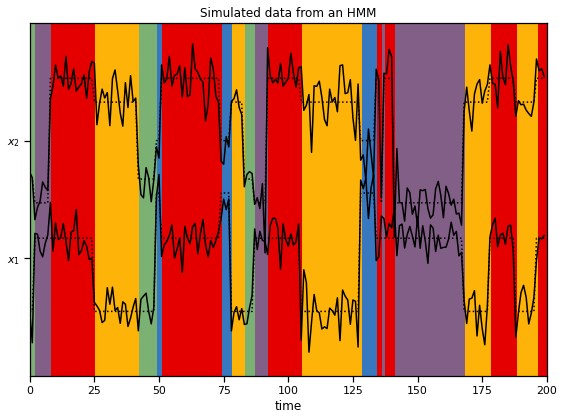

In [7]:
# Make a "true" HMM
num_states = 5
data_dim = 2
true_hmm = GaussianHMM(num_states, data_dim)

# Override the emission distribution
true_hmm.emission_means = torch.column_stack([
    torch.cos(torch.linspace(0, 2 * torch.pi, num_states+1))[:-1],
    torch.sin(torch.linspace(0, 2 * torch.pi, num_states+1))[:-1]
])
true_hmm.emission_covs = 0.25**2 * torch.eye(data_dim).repeat(num_states, 1, 1)

# Sample the model
num_timesteps = 200
states, emissions = true_hmm.sample(num_timesteps, seed=305+ord('c'))

# Plot the data and the smoothed data
lim = 1.05 * abs(emissions).max()
plt.figure(figsize=(8, 6))
plt.imshow(states[None,:],
           aspect="auto",
           interpolation="none",
           cmap=helpers.cmap,
           vmin=0,
           vmax=len(helpers.colors)-1,
           extent=(0, num_timesteps, -lim, (data_dim)*lim))

means = true_hmm.emission_means[states]
for d in range(data_dim):
    plt.plot(emissions[:,d] + lim * d, '-k')
    plt.plot(means[:,d] + lim * d, ':k')

plt.xlim(0, num_timesteps)
plt.xlabel("time")
plt.yticks(lim * torch.arange(data_dim), ["$x_{}$".format(d+1) for d in range(data_dim)])

plt.title("Simulated data from an HMM")

plt.tight_layout()

## Fit the Gaussian HMM to synthetic data

  0%|          | 0/100 [00:00<?, ?it/s]

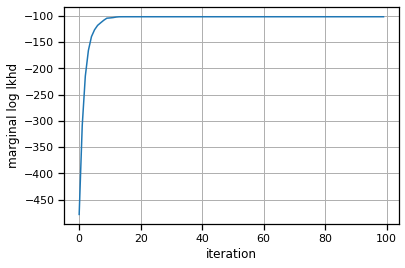

In [10]:
# Build the HMM and fit it with EM
hmm = GaussianHMM(num_states, data_dim)
lls, posterior = hmm.fit(emissions)

# Plot the log likelihoods. They should go up.
plt.plot(lls)
plt.xlabel("iteration")
plt.ylabel("marginal log lkhd")
plt.grid(True)

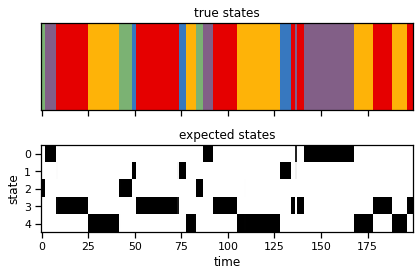

In [11]:
# Plot the true and inferred states
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].imshow(states[None,:],
              aspect="auto",
              interpolation="none",
              cmap=helpers.cmap,
              vmin=0, vmax=len(helpers.colors)-1)
axs[0].set_yticks([])
axs[0].set_title("true states")

axs[1].imshow(posterior.expected_states.T,
              aspect="auto",
              interpolation="none",
              cmap="Greys",
              vmin=0, vmax=1)
axs[1].set_yticks(torch.arange(num_states))
axs[1].set_ylabel("state")
axs[1].set_xlabel("time")
axs[1].set_title("expected states")

plt.tight_layout()

## Problem 2b [Code]: Cross validation

Fit HMMs with varying numbers of discrete states, $K$, and compare them on held-out test data. For each $K$, fit an HMM multiple times from different initial conditions to guard against local optima in the EM fits. Plot the held-out likelihoods as a function of $K$.


Attempting num_states = 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Attempting num_states = 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Attempting num_states = 4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Attempting num_states = 5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Attempting num_states = 6


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Attempting num_states = 7


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Attempting num_states = 8


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Attempting num_states = 9


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

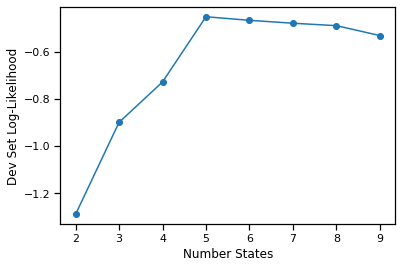

In [13]:
num_restarts = 5 # number of restarts to do
state_seq = torch.arange(2, 10) # number of states to try
### sample an actual sequence
states_cv, emissions_cv = true_hmm.sample(400, seed=305+ord('c'))
# test 0:train_cut, dev train_cut:dev_cut, test dev_cut:
train_cut, dev_cut = 300, 350
results_val = []
# iter over states
for num_states_ in state_seq:
    print(f"Attempting num_states = {num_states_}")
    cv_lls = []
    for iter in range(num_restarts):
        torch.manual_seed(iter)
        hmm_cv_iter = GaussianHMM(num_states_, data_dim)
        lls_train, posterior_train = hmm_cv_iter.fit(emissions_cv[0:train_cut])

        # compute liks across dev set, by subtracting out train set
        cv_likelihood = (
            hmm_cv_iter.compute_marginal_ll(emissions_cv[0:dev_cut]) 
            - hmm_cv_iter.compute_marginal_ll(emissions_cv[0:train_cut])
        ) / (dev_cut - train_cut)

        cv_lls.append(cv_likelihood)
    results_val.append(cv_lls)

results_val = torch.vstack([torch.tensor(item) for item in results_val]) 

### plot the CV
plt.plot(state_seq, results_val.mean(axis=1))
plt.scatter(state_seq, results_val.mean(axis=1))
plt.xlabel("Number States")
plt.ylabel("Dev Set Log-Likelihood")
plt.show()

## Problem 2c [Short Answer]: Discussion

With my code, the HMM doens't always find the true latent states. Sometimes it merges the red and blue states, for example. Aside from running multiple restarts with random initializations, what strategies could you use to address this challenge?

---

We appear to have seen this collapsing state behavior in 2A above, where the 0th state appears to have collapsed with the 1st state (hence, no zero states). Remedies for this could include: (i) altering the initial/entry distribution, (ii) updating the transition matrix (also a forward/backward) to encourage visitation of the neglected states; (iii) add priors on an updating transition matrix to encourage such visitation. 
Additionally, it may make sense to enforce some sort of ordering on the states, so that the 0th state is always most probable, the 1st the second most probable, etc.

---

# Part 3: Autoregressive HMMs

Autoregressive hidden Markov models (ARHMMs) replace the Gaussian observations with an AR model:
\begin{align}
p(x, z \mid \Theta) &= \mathrm{Cat}(z_1 \mid \pi) \prod_{t=2}^{T} \mathrm{Cat}(z_t \mid P_{z_{t-1}}) \prod_{t=1}^T p(x_t \mid x_{1:t-1}, z_t)
\end{align}
The model is "autoregressive" because $x_t$ depends not only on $z_t$ but on $x_{1:t-1}$ as well. The precise form of this dependence varies; here we will consider linear Gaussian dependencies on only the most recent $L$ timesteps,:
\begin{align}
p(x_t \mid x_{1:t-1}, z_t) &= \mathcal{N}\left(x_t \mid \sum_{l=1}^L A_{z_t,l} x_{t-l} + b_{z_t}, Q_{z_t} \right)  \qquad \text{for } t > L
\end{align}
To complete the model, assume
\begin{align}
p(x_t \mid x_{1:t-1}, z_t) &= \mathcal{N}\left(x_t \mid 0, I \right)  \qquad \text{for } t \leq L
\end{align}

The new parameters are $\Theta = \pi, P, \{\{A_{k,l}\}_{l=1}^L, b_{k}, Q_k\}_{k=1}^K$, which include weights $A_{k,l} \in \mathbb{R}^{D \times D}$ for each of the $K$ states and the $L$ lags, and a bias vector $b_k \in \mathbb{R}^D$.

Note that we can write this as a simple **linear regression**,
\begin{align}
p(x_t \mid x_{1:t-1}, z_t) &= \mathcal{N}\left(x_t \mid W_k \phi_t , Q_{z_t} \right)  
\end{align}
where $\phi_t = (x_{t-1}, \ldots, x_{t-L}, 1) \in \mathbb{R}^{LD +1}$ is a vector of covariates (aka features) that includes the past $L$ time steps along with a 1 for the bias term.
\begin{align}
W_k = \begin{bmatrix} A_{k,1}  & A_{k,2} & \ldots & A_{kL} & b_k \end{bmatrix}
\in \mathbb{R}^{D \times LD + 1}
\end{align}
is a block matrix of the autoregressive weights and the bias. 

_Note that the covariates are fixed functions of the data so we can precompute them, if we know the number of lags $L$._ 

## Problem 3a [Math]: Derive the natural parameters and sufficient statistics for a linear regression

Expand the expected log likelihood of a linear regression model in terms of $W_k$ and $b_k$,
\begin{align}
\mathbb{E}_{q(z)}\left[ \sum_{t=1}^T \mathbb{I}[z_t=k] \cdot \log \mathcal{N}(x_t \mid W_k \phi_t, Q_k) \right].
\end{align}
Write it as a sum of inner products between natural parameters (i.e. functions of $W_k$ and $Q_k$) and expected sufficient statistics (i.e. functions of $q$, $x$ and $\phi$). 

---

We have
\begin{align}
\mathbb{E}_{q(z)}\left[ \cdot \right]
&=
\mathbb{E}_{q(z)}\left[ \sum_{t=1}^L \mathbb{I}[z_t=k] \cdot \log \mathcal{N}(x_t \mid 0_d, I_d) \right]+ \\
&\hspace{1.5cm}
\mathbb{E}_{q(z)}\left[ \sum_{t=L+1}^T \mathbb{I}[z_t=k] \cdot \log \mathcal{N}(x_t \mid W_k \phi_t, Q_k) \right] \\
&=
\sum_{t\leq L}q(z_t=k)\bigg[-\frac{D}{2}\log (2\pi)-\frac{1}{2}x_t^Tx_t \bigg] \\
&\hspace{1.5cm} +
\sum_{t> L}q(z_t=k)\bigg[-\frac{D}{2}\log (2\pi) -\frac{1}{2}\log|Q_k|
-\frac{1}{2}(x_t - W_k\phi_t)^TQ_k^{-1}(x_t - W_k\phi_t)\bigg]\\
&=
\sum_{t\leq L}q(z_t=k)\bigg[-\frac{D}{2}\log (2\pi)-\frac{1}{2}x_t^Tx_t \bigg] \\
&\hspace{1.5cm} + 
\sum_{t> L}q(z_t=k)\bigg[
  -\frac{D}{2}\log (2\pi) -\frac{1}{2}\log|Q_k| 
-\frac{1}{2}x_t^TQ_k^{-1}x_t + x_t^TQ_k^{-1}W_k\phi_t -\frac{1}{2}\phi_t^T W_k^T Q_k^{-1}W_k \phi_t
\bigg] \\
&=
-\underbrace{\frac{D}{2}\log(2\pi)\sum_{t, k}q(z_t=k)}_{c_1}  \\&\hspace{1.5cm}
- \underbrace{
  \frac{1}{2}\sum_{t\leq L}q(z_t=k)q(z_t=k)x_t^Tx_t
 }_{c_2} \\&\hspace{1.5cm}
-\frac{1}{2}\sum_{t> L}q(z_t=k)\log|Q_k|\\&\hspace{1.5cm}
-\frac{1}{2}\sum_{t> L}q(z_t=k) x_t^TQ_k^{-1}x_t \\&\hspace{1.5cm} 
+ \sum_{t> L} q(z_t=k) \phi_t^TW_k^TQ_k^{-1}x_t  \\&\hspace{1.5cm} 
-\frac{1}{2}\sum_{t> L}q(z_t=k) \phi_t^TW_k^TQ_k^{-1} W_k \phi_t \\
&=
-\frac{1}{2}\sum_{t> L}q(z_t=k)\log|Q_k|\\&\hspace{1.5cm}
-\frac{1}{2}tr\bigg\{Q_k^{-1}
  \sum_{t> L}q(z_t=k) x_tx_t^T\bigg\} \\&\hspace{1.5cm} 
  + tr\bigg\{W_k^TQ_k^{-1}\sum_{t> L} q(z_t=k) x_t\phi_t^T\bigg\}  \\&\hspace{1.5cm} 
-\frac{1}{2}tr\bigg\{
  \phi_t^TW_k^TQ_k^{-1} W_k \phi_t 
  \sum_{t> L}q(z_t=k) \bigg\}\\
&=
c  
-\frac{1}{2}
  tr\bigg\langle \log|Q_k|, 
  \underbrace{\sum_{t> L}q(z_t=k)}_{T_1}
\bigg\rangle\\&\hspace{1.5cm}
%%%%%%%
-\frac{1}{2}
tr\bigg\langle 
  Q_k^{-1}, 
  \underbrace{\sum_{t> L}q(z_t=k) x_tx_t^T}_{T_2}
\bigg\rangle \\&\hspace{1.5cm} 
%%%%%%%
+ tr\bigg\langle  
    W_k^TQ_k^{-1}, 
    \underbrace{\sum_{t> L} q(z_t=k)x_t\phi_t^T}_{T_3}
  \bigg\rangle \\&\hspace{1.5cm}
%%%%%%%
-\frac{1}{2}
  tr\bigg\langle 
     W_k^TQ_k^{-1}W_k, 
     \underbrace{\sum_{t> L}q(z_t=k)}_{T_4}\phi_t\phi_t^T
  \bigg\rangle
\end{align}

---


## Problem 3b [Math]: Solve for the optimal linear regression parameters given expected sufficient statistics

Solve for $W_k^\star, Q_k^\star$ that maximize the objective above in terms of the expected sufficient statistics.


---

The objective is thus
\begin{align}
\ell(W_k, Q_k)
=
-\frac{1}{2}tr\{ \log|Q_k| T_1\}
 -\frac{1}{2}tr\{ Q_k^{-1} T_2\}
 + tr\{W_k^TQ_k^{-1}T_3\}
  -\frac{1}{2}tr\{ W_k^TQ_k^{-1}W_k T_4\}.
\end{align}
Taking a derivative wrt $W_k$ and setting to zero gives


\begin{align}
\\
\frac{d\ell(W_k, Q_k)}{ dW_k^T}
&=0 \\
&=
-\frac{1}{2}tr\{ \log|Q_k| T_1\}
 -\frac{1}{2}tr\{ Q_k^{-1} T_2\} \\&\hspace{1.5cm}
 + tr\{W_k^TQ_k^{-1}T_3\}
  -\frac{1}{2}tr\{ W_k^TQ_k^{-1}W_k T_4\} \\
&=
(Q_k^{-1}T_3)^T - (Q_k^{-1}W_kT_4)^T \\
&=
T_3 Q_k^{-1} - T_4^T W_k^T Q_k^{-1} \\
&=
T_3 Q_k^{-1} - T_4 W_k^T Q_k^{-1} \\
&=
T_3^T  - T_4 W_k^T\\\\
\implies & W_k^{*} = T_3 T_4^{-1},
\end{align}

which works because recall $T_4$ is comprised of a sum of $\phi_t\phi_t^T \in \mathbb{R}^{(LD + 1) \times (LD + 1)}$ and hence is PSD and invertible (also symmetric, which is used above).

Next, we plug this into the likelihood, take a derivative wrt $Q_k$, and solve for $Q_k$, i.e.

\begin{align}
\ell(W_k^*, Q_k)
&=
-\frac{1}{2}tr\{ \log|Q_k| T_1\}
 -\frac{1}{2}tr\{ Q_k^{-1} T_2\}\\&\hspace{1.5cm}
 + tr\{W_k^{*T}Q_k^{-1}T_3\}
  -\frac{1}{2}tr\{ W_k^{*T}Q_k^{-1}W_k^* T_4\} \\
&=
\frac{1}{2}\log|Q_k^{-1}| T_1
 -\frac{1}{2}tr\{ Q_k^{-1} T_2\}\\&\hspace{1.5cm}
 + tr\{T_3W_k^{*T}Q_k^{-1}\}
  -\frac{1}{2}tr\{ W_k^* T_4 W_k^{*T}Q_k^{-1}\}.
\end{align}

A quick dim-check for the final three terms, for $M = LD + 1$:

- $Q_k^{-1}T_2: (D\times D) \times (D \times D) = D\times D$. 

- $T_3W_k^{*T}Q_k^{-1}: (D\times M) \times (M\times D) \times (D \times D) = D\times D$. 

- $W_k^* T_4 W_k^{*T}: (D\times M)\times (M\times M) \times (M \times D) \times (D \times D) = D\times D$. 

Then, we taken another derivative and set to zero
\begin{align}
\nabla_{Q_k^{-1}}\ell(W_k^*, Q_k)
&=
0 \\&=
\nabla_{Q_k^{-1}}\bigg[\frac{1}{2}\log|Q_k^{-1}| T_1
 -\frac{1}{2}tr\{ Q_k^{-1} T_2\}\\&\hspace{1.5cm}
 + tr\{T_3W_k^{*T}Q_k^{-1}\}
  -\frac{1}{2}tr\{ W_k^* T_4 W_k^{*T}Q_k^{-1}\} \bigg]\\
  &= T_1 Q_k - \frac{1}{2}T_2^T + W_k^*T_3^T  - \frac{1}{2}W_k^* T_4^T W_k^{*T} \\
  &= T_1 Q_k - \frac{1}{2}T_2 + W_k^*T_3^T  - \frac{1}{2} W_k^* T_4 W_k^{*T}.
\end{align}
Again, dim-check holds up, and it's important to note that $T_2, T_4$ are symmetric, which gives the final simplification. Then, we solve for $Q_k$. 

$$
Q_k  =  \frac{1}{T_1}\bigg[\frac{1}{2}T_2 - W_k^*T_3^T +  \frac{1}{2} W_k^* T_4 W_k^{*T}\bigg]
$$

---

## Problem 3c [Code]: Implement an Autoregressive HMM

Now complete the code below to implement an AR-HMM. 

_Note: This code assumes $L=1$_.

In [12]:
class AutoregressiveHMM:
    """
    Simple implementation of an Autoregressive HMM.
    """
    def __init__(self, num_states, data_dim):
        self.num_states = num_states
        self.data_dim = data_dim

        # Initialize the HMM parameters
        self.initial_probs = torch.ones(num_states) / num_states
        self.initial_mean = torch.zeros(data_dim)
        self.initial_cov = torch.eye(data_dim)
        self.transition_matrix = \
            0.9 * torch.eye(num_states) + \
            0.1 * torch.ones((num_states, num_states)) / num_states
        self.emission_dynamics = torch.randn(num_states, data_dim, data_dim)
        self.emission_bias = torch.randn(num_states, data_dim)
        self.emission_cov = torch.eye(data_dim).repeat(num_states, 1, 1)

    def sample(self, num_timesteps, seed=0):
        """
        Sample the HMM
        """
        # Set random seed
        torch.manual_seed(seed)

        # Initialize outputs
        states = torch.full((num_timesteps,), -1, dtype=int)
        data = torch.zeros((num_timesteps, self.data_dim))

        # get the initial probability distribution of latent states
        state_probs = self.initial_probs

        # Sample the initial state
        states[0] = Categorical(probs=state_probs).sample() 

        # sample initial emission
        # this is the only one from N(0, I) as L = 1 
        data[0, :] = MultivariateNormal(self.initial_mean, self.initial_cov).sample() 

        for t in range(1, num_timesteps):
            k = states[t - 1]

            # find the new mean and covariance for next state 
            # mu = A_k @ x_(t - 1) + b_k
            # Sigma = Q_k
            mu  = self.emission_dynamics[k, :, :] @ data[t - 1, :]
            mu += self.emission_bias[k, :]
            Sigma = self.emission_cov[k, :, :]

            # sample the emission
            data[t, :] = MultivariateNormal(loc=mu, covariance_matrix=Sigma).sample()
            if t < num_timesteps - 1:
                state_probs = self.transition_matrix[states[t]]

                # sample next state 
                states[t+1] = Categorical(probs=state_probs).sample()

        return states, data


    def e_step(self, data):
        """Perform one e-step to compute the posterior over the latent states
        given the data.
        """
        ###
        # handle dims
        T, D = data.shape
        assert D == self.data_dim
        K = self.num_states

        ### Part I: Calculate log-likes under model ###
        log_likes = torch.zeros((T, K))

        for t in range(T):
            if t == 0:
                mu_t, cov_t = self.initial_mean, self.initial_cov
            else:
                # Note that AR(1) creates the following special cases
                #  - M = D, also bias is now separate
                #  - data[t-1] is only one slice, and not data[t-lag:t-1]
                mu_t = torch.add(
                    # (K, M=D)*(M=D, D) // note it's t-1 only because of 
                    self.emission_dynamics @ data[t - 1], # (K, D)
                    self.emission_bias # (K, D)
                ) # -> (K, D)
                assert mu_t.shape == torch.Size([K, D])
                cov_t = self.emission_cov # (K, D, D)
                assert cov_t.shape == torch.Size([K, D, D])
            # compute LL
            log_likes[t, :] = MultivariateNormal(
                loc=mu_t, 
                covariance_matrix=cov_t
            ).log_prob(
                data[t]
            )

        posterior = forward_backward(self.initial_probs, 
                                     self.transition_matrix, 
                                     log_likes)
        
        return posterior

    def m_step(self, data, posterior):
        """Perform one m-step to update the emission means and covariance given the
        data and the posteriors output by the forward-backward algorithm.
        """
        ##
        K = self.num_states
        T, D = data.shape

        # recall it's for t > L, so just filter on that
        q_z = posterior.expected_states[1:]
        _onevec = torch.ones(q_z.shape[0]).reshape(-1, 1)
        # redundant, but easier to follow from above
        Xt = data[1:]
        phi_t = torch.hstack([_onevec, data[:-1]])

        ### I. synthetic "counts" ###
        T1 = q_z.sum(axis=0)

        ### II. second SS ###
        # pre multiply the row-wise weights (too big for diagonal)
        Xt_wt_T = torch.multiply(
            Xt.unsqueeze(2), # (N, D, 1)
            q_z.unsqueeze(1) # (N, 1, K)
        ).swapaxes(0, 2) # (K, D, N)

        T2 = torch.stack([
            item @ Xt for item in Xt_wt_T
        ]) # (K, D, D)


        ### III. third SS ###
        # again, phi_t is just one lag; reuse premultiplied X^T
        T3 = torch.stack([
            item @ phi_t for item in Xt_wt_T
        ]) # (K, D, M)


        ### IV. fourth ss ###
        # premultiply
        phi_wt_T = torch.multiply(
            phi_t.unsqueeze(2), # (N, D, 1)
            q_z.unsqueeze(1) # (N, 1, K)
        ).swapaxes(0, 2) # (K, D, N)

        T4 = torch.stack([
            item @ phi_t for item in phi_wt_T
        ]) # (K, M, M)

        ### mean ###
        W_new = torch.stack(
            [
            T3[k] @ torch.linalg.inv(T4[k])
            for k in range(K)
            ]
        )
        ### covariance ###
        Q_new = torch.stack(
            [
              (1 / T1[k]) * (
                  (1. / 2.) * T2[k]
                  - W_new[k] @ T3[k].T
                  + (1./ 2.) * W_new[k] @ T4[k] @ W_new[k].T
              )
            for k in range(K)
            ]
        )
        Q_new = 0.5 * (Q_new + Q_new.transpose(1, 2)) + 1e-4 * torch.eye(D)

        # decouple bias from the matrix
        emission_bias_new = W_new[:, :, 0]
        emission_dynamics_new = W_new[:, :, 1:]

        assert emission_dynamics_new.shape == self.emission_dynamics.shape
        assert emission_bias_new.shape == self.emission_bias.shape
        assert Q_new.shape == self.emission_cov.shape

        self.emission_dynamics = emission_dynamics_new
        self.emission_bias = emission_bias_new
        self.emission_cov = Q_new
        #
        ##

    def fit(self, data, num_iters=100):
        """
        Estimate the parameters of the HMM with expectation-maximization (EM).
        """
        # Initialize the posterior randomly
        expected_states = F.softmax(torch.randn(len(data), num_states), dim=0)
        posterior = HMMPosterior(expected_states=expected_states,
                                 marginal_ll=-torch.inf)
        
        # Track the marginal log likelihood of the data over EM iterations
        lls = []

        # Main loop of the EM algorithm
        for itr in trange(num_iters):
            # perform the E-step: compute posterior probabilities
            posterior = self.e_step(data)

            # Track the log likeliood
            lls.append(posterior.marginal_ll)

            # perform the M-step: updating model parameters
            self.m_step(data, posterior)

        # convert lls to arrays and return
        lls = torch.tensor(lls)
        return lls, posterior            

## Sample synthetic data from the model

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


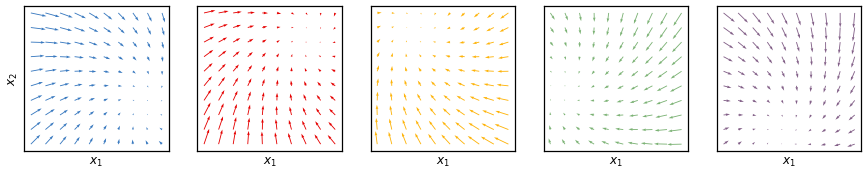

In [13]:
# Make observation distributions
num_states = 5
data_dim = 2

# Initialize the transition matrix to proceed in a cycle
transition_probs = (torch.arange(num_states)**10).type(torch.float)
transition_probs /= transition_probs.sum()
transition_matrix = torch.zeros((num_states, num_states))
for k, p in enumerate(transition_probs.flip(0)):
    transition_matrix += torch.roll(p * torch.eye(num_states), k, dims=1)

# Initialize the AR dynamics to spiral toward points
rotation_matrix = \
    lambda theta: torch.tensor([[torch.cos(theta), -torch.sin(theta)],
                                [torch.sin(theta),  torch.cos(theta)]])
theta = torch.tensor(-torch.pi / 25)
dynamics = 0.8 * rotation_matrix(theta).repeat(num_states, 1, 1)
bias = torch.column_stack([torch.cos(torch.linspace(0, 2*torch.pi, num_states+1)[:-1]), 
                        torch.sin(torch.linspace(0, 2*torch.pi, num_states+1)[:-1])])
covs = torch.tile(0.001 * torch.eye(data_dim), (num_states, 1, 1))

# Compute the stationary points
stationary_points = torch.linalg.solve(torch.eye(data_dim) - dynamics, bias)

# Construct an ARHMM and overwrite the emission parameters
true_arhmm = AutoregressiveHMM(num_states, data_dim)
true_arhmm.transition_matrix = transition_matrix
true_arhmm.emission_dynamics = dynamics
true_arhmm.emission_bias = bias
true_arhmm.emission_cov = covs

# Plot the true ARHMM dynamics for each of the 5 states
helpers.plot_dynamics(true_arhmm)


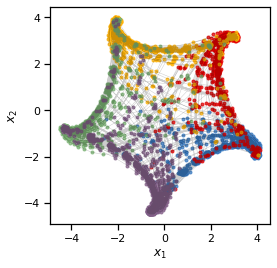

In [14]:
# Sample from the true ARHMM
states, data = true_arhmm.sample(10000, seed=305+ord('c'))

# Plot the data
for k in range(num_states):
    plt.plot(*data[states==k].T, 'o', color=helpers.colors[k],
         alpha=0.75, markersize=3)
    
plt.plot(*data.T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect("equal")

## Fit an ARHMM to the synthetic data

  0%|          | 0/25 [00:00<?, ?it/s]

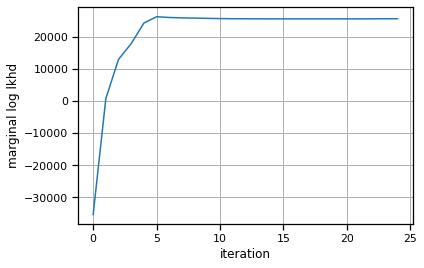

In [21]:
# Construct another ARHMM and fit it with EM
arhmm = AutoregressiveHMM(num_states, data_dim)
lls, posterior = arhmm.fit(data, num_iters=25)

# Plot the log likelihoods. They should go up.
plt.plot(lls)
plt.xlabel("iteration")
plt.ylabel("marginal log lkhd")
plt.grid(True)

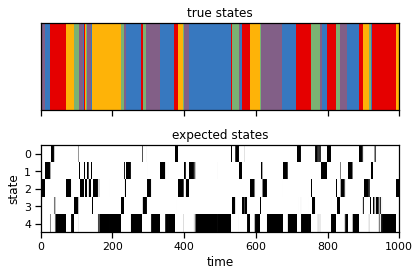

In [18]:
# Plot the true and inferred states
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].imshow(states[None,:],
              aspect="auto",
              interpolation="none",
              cmap=helpers.cmap,
              vmin=0, vmax=len(helpers.colors)-1)
axs[0].set_xlim(0, 1000)
axs[0].set_yticks([])
axs[0].set_title("true states")

axs[1].imshow(posterior.expected_states.T,
              aspect="auto",
              interpolation="none",
              cmap="Greys",
              vmin=0, vmax=1)
axs[1].set_xlim(0, 1000)
axs[1].set_yticks(torch.arange(num_states))
axs[1].set_ylabel("state")
axs[1].set_xlabel("time")
axs[1].set_title("expected states")
plt.tight_layout()

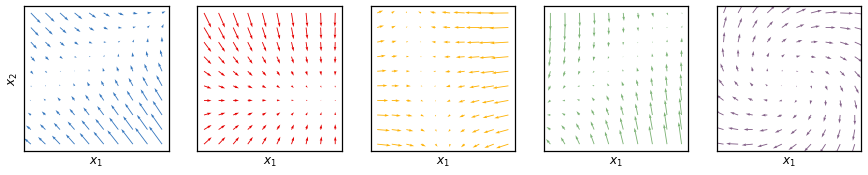

In [19]:
# Plot the learned dynamics
helpers.plot_dynamics(arhmm)

As with the Gaussian HMM, you may find that the ARHMM doesn't perfectly learn the true underlying states. 

# Part 4: Fit the ARHMM to mouse videos


Now we'll load in some real data from depth video recordings of freely moving mice. This data is from the Datta Lab at Harvard Medical School. The references are given at the top of this notebook.

The video frames, even after cropping, are still 80x80 pixels. That's a 3600 dimensional observation. In practice, the frames can be adequately reconstructed with far fewer principal components. As little as ten PCs does a pretty good job of capturing the mouse's posture.

The Datta lab has already computed the principal components and included them in the NWB. We'll extract them, along with other relevant information like the centroid position and heading angle of the mouse, which we'll use for making "crowd" movies below. Finally, they also included labels from MoSeq, an autoregressive (AR) HMM. You'll build an ARHMM in Part 3 of the lab and infer similar discrete latent state sequences yourself!

In [5]:
# Load one session of data
data_dim = 10
train_dataset, test_dataset = helpers.load_dataset(indices=[0], num_pcs=data_dim)
train_data = train_dataset[0]
test_data = test_dataset[0]

  0%|          | 0/1 [00:00<?, ?it/s]

You should now have a `train_dataset` and a `test_dataset` loaded in memory. Each dataset is a list of dictionaries, one for each mouse. Each dictionary contains a few keys, most important of which is the `data` key, containing the standardized principal component time series, as shown above. For the test dataset, we also included the `frames` key, which has the original 80x80 images. We'll use these to create the movies of each inferred state.

**Note:** Keeping the data in memory is costly but convenient.  You shouldn't run out of memory in this lab, but if you ever did, a better solution might be to write the preprocessed data (e.g. with the standardized PC trajectories) back to the NWB files and reload those files as necessary during fitting.

## Plot a slice of data 
In the background, we're showing the labels that were given to us from MoSeq, an autoregressive hidden Markov model.

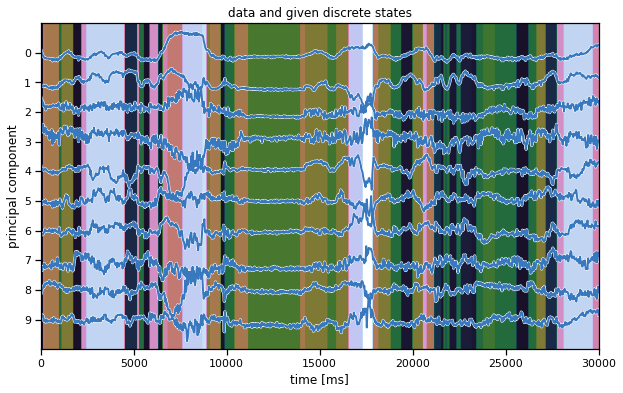

In [6]:
  helpers.plot_data_and_states(
      train_data, train_data["labels"],
      title="data and given discrete states")

## Fit it!

With my implementation, this takes about 5 minutes to run on Colab. 

  0%|          | 0/50 [00:00<?, ?it/s]

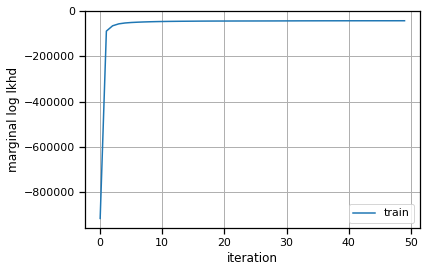

In [7]:
# Build the HMM
num_states = 25
data_dim = 10
arhmm = AutoregressiveHMM(num_states, data_dim)

# Fit it!
lls, posterior = arhmm.fit(torch.tensor(train_data["data"]), 
                           num_iters=50)

plt.plot(lls, label="train")
plt.xlabel("iteration")
plt.ylabel("marginal log lkhd")
plt.grid(True)
plt.legend()

## Plot the data and the inferred states


We'll make the same plot as above (in the warm-up) but using our inferred states instead. Hopefully, the states seem to switch along with changes in the data. 

**Note**: We're showing the state with the highest marginal probability, $z_t^\star = \mathrm{arg} \, \mathrm{max}_k \; q(z_t = k)$. This is different from the most likely state path, $z_{1:T}^\star = \mathrm{arg}\,\mathrm{max} \; q(z)$. We could compute the latter with the Viterbi algorithm, which is similar to the forward-backward algorithm you implemented above.

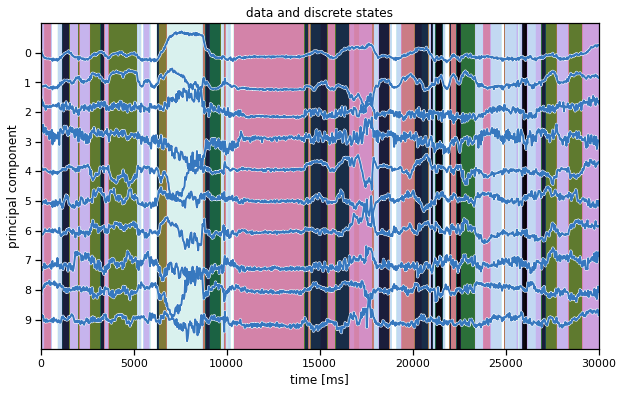

In [8]:
arhmm_states = posterior.expected_states.argmax(1)
helpers.plot_data_and_states(train_data, arhmm_states)

## Plot the state usage histogram


The state usage histogram shows how often each discrete state was used under the posterior distribution. You'll probably see a long tail of states with non-trivial usage (hundreds of frames), all the way out to state 50. That suggests the model is using all its available capacity, and we could probably crank the number of states up even further for this model.

Text(0.5, 1.0, 'histogram of inferred state usage')

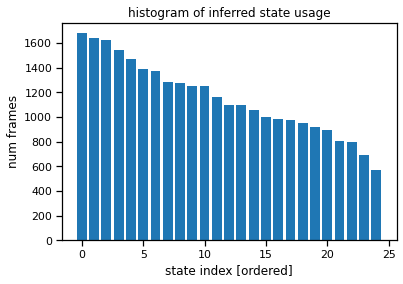

In [9]:
# Sort states by usage
arhmm_states = posterior.expected_states.argmax(1)
arhmm_usage = torch.bincount(arhmm_states, minlength=num_states)
arhmm_order = torch.argsort(arhmm_usage).flip(0)

plt.bar(torch.arange(num_states), arhmm_usage[arhmm_order])
plt.xlabel("state index [ordered]")
plt.ylabel("num frames")
plt.title("histogram of inferred state usage")

## Plot some "crowd" movies

In [10]:
test_posterior = arhmm.e_step(torch.tensor(test_data["data"]))

In [11]:
helpers.play(helpers.make_crowd_movie(
    int(arhmm_order[0]), [test_data], [test_posterior]))

Preparing animation. This may take a minute...


In [12]:
helpers.play(helpers.make_crowd_movie(
    int(arhmm_order[1]), [test_data], [test_posterior]))

Preparing animation. This may take a minute...


In [13]:
helpers.play(helpers.make_crowd_movie(
    int(arhmm_order[2]), [test_data], [test_posterior]))

Preparing animation. This may take a minute...


In [14]:
helpers.play(helpers.make_crowd_movie(
    int(arhmm_order[3]), [test_data], [test_posterior]))

Preparing animation. This may take a minute...


In [15]:
helpers.play(helpers.make_crowd_movie(
    int(arhmm_order[4]), [test_data], [test_posterior]))

Preparing animation. This may take a minute...


In [16]:
helpers.play(helpers.make_crowd_movie(
    int(arhmm_order[20]), [test_data], [test_posterior]))

Preparing animation. This may take a minute...


## Download crowd movies for all states

In [17]:
# Make "crowd" movies for each state and save them to disk
# Then you can download them and play them offline
for i in trange(num_states):
    helpers.play(helpers.make_crowd_movie(
        int(arhmm_order[i]), [test_data], [test_posterior]),
        filename="arhmm_crowd_{}.mp4".format(i), show=False)

# Zip the movies up    
!zip arhmm_crowd_movies.zip arhmm_crowd_*.mp4

# Download the files as a zip
files.download("arhmm_crowd_movies.zip")

  0%|          | 0/25 [00:00<?, ?it/s]

  adding: arhmm_crowd_0.mp4 (deflated 7%)
  adding: arhmm_crowd_10.mp4 (deflated 8%)
  adding: arhmm_crowd_11.mp4 (deflated 3%)
  adding: arhmm_crowd_12.mp4 (deflated 4%)
  adding: arhmm_crowd_13.mp4 (deflated 6%)
  adding: arhmm_crowd_14.mp4 (deflated 22%)
  adding: arhmm_crowd_15.mp4 (deflated 12%)
  adding: arhmm_crowd_16.mp4 (deflated 8%)
  adding: arhmm_crowd_17.mp4 (deflated 4%)
  adding: arhmm_crowd_18.mp4 (deflated 2%)
  adding: arhmm_crowd_19.mp4 (deflated 8%)
  adding: arhmm_crowd_1.mp4 (deflated 3%)
  adding: arhmm_crowd_20.mp4 (deflated 8%)
  adding: arhmm_crowd_21.mp4 (deflated 2%)
  adding: arhmm_crowd_22.mp4 (deflated 10%)
  adding: arhmm_crowd_23.mp4 (deflated 11%)
  adding: arhmm_crowd_24.mp4 (deflated 6%)
  adding: arhmm_crowd_2.mp4 (deflated 6%)
  adding: arhmm_crowd_3.mp4 (deflated 7%)
  adding: arhmm_crowd_4.mp4 (deflated 3%)
  adding: arhmm_crowd_5.mp4 (deflated 5%)
  adding: arhmm_crowd_6.mp4 (deflated 6%)
  adding: arhmm_crowd_7.mp4 (deflated 6%)
  adding: arhmm

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Problem 4a [Short Answer]: Discussion

Now that you've completed the analysis, discuss your findings in one or two paragraphs. Some questions to consider (though you need not answer all) are:
- Did any interesting states pop out in your crowd movies? 
- Are the less frequently used states interesting or are they just noise? 
- It took a few minutes to fit data from a single mouse with ~50,000 frames of video. In practice, we have data from dozens of mice and millions of frames of video. What approaches might you take to speed up the fitting procedure?
- Aside from runtime, what other challenges might you encounter when fitting the same model to multiple mice? What could you do to address those challenges?
- The ARHMM finds reasonable looking discrete states ("syllables") but it's surely not a perfect model. What changes could you make to better model mouse behavior?

---

First, playing the videos, the model seems to produce generally reasonable rodent behavior -- you see them scurry, turn, and move their heads in the way one might expect them to. So that's good overall; the crowd movies generally aligned with those previewed in lecture.  

In terms of most frequent states, the zero state is far and away the most common. In looking through the paper, this seems to correspond to walking (makes sense); while there is a big drop off after walking, "pause" and "low-rear" appear next-most present in both the videos, which makes some amount of sense, as those are common behaviors. There are also three more semi-frequent states/actions whose names I am unsure of (not very familiar with mice posture), followed by a precipitous drop off. This would suggest that at least according to this sample, there is a most frequent maneuever (walk) followed by five semi-frequent maneuvers, with all others rarer. *Notably, if on experimentation with different initializations, I saw some runs return a more uniform/even (still decaying R/L though, with the three aforementioned behaviors at the top) split of behavior. So the EM dynamics may have some influence here, and perhaps multiple restarts and/or some sort of model averaging could help reduce variance.*

While the experiment generally worked well, there are a number of areas we could try to improve. In addition to the ensembling above, we might:

- Resize/rescale pictures to account for mouse size, lest the model confuse Behavior A from a large mouse with Behavior A from a small mouse on account of size alone. 

- We might want to define and hand-label some mouse behaviors, label a training set, and use those to inform priors for the latent states. This would encourage the latent states to align with a biomechanical understanding of mice movement. 

- We fit on one mouse at a time here, and hence it might be unreasonable to use single-mouse trajectories to generate batches of mice. For one, mice might behave differently in batches, and the single-mouse fit would fail to account for this. Relatedly, the single-mouse fit wouldn't respect spatial relationships -- as seen in the videos, the mice just run right over one another, and there is no behavior learned by the model for a mouse to step around/over/under another mouse when there is a collision. In other words, a mouse may move in a straight line when trying to do "walk" behavior in its own exhibit; if it was on a collision course with another mouse, however, it might have to do "walk"-"pause"-"walk", which is not learned in this setting.

- To speed up fit, we might break the frames down into batches and live with smaller trajectories. Moreover, we might push for variational approximations or more deep-learning/big-dataset-friendly techniques, such as RNN or LSTM.

---

**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw7_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf file to Gradescope. 